In [40]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import compute_meandice
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
    ResizeD
)
from monai.utils import first, set_determinism

In [47]:
trainFolder = '/home/roshansk/Covid/Live/ircad-dataset/train/'
root_dir = '/home/roshansk/Covid/Live/'

trainFiles  = os.listdir(trainFolder)

imgFiles = [os.path.join(trainFolder,x) for x in trainFiles if 'orig' in x]
labelFiles = [x.replace('orig','liver') for x in imgFiles]

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(imgFiles, labelFiles)
]

train_files, val_files = data_dicts[:-7], data_dicts[-7:]

In [18]:
set_determinism(seed=0)

In [19]:
# train_transforms = Compose(
#     [
#         LoadNiftid(keys=["image", "label"]),
#         AddChanneld(keys=["image", "label"]),
#         Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         ScaleIntensityRanged(
#             keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         RandCropByPosNegLabeld(
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=(96, 96, 96),
#             pos=1,
#             neg=1,
#             num_samples=4,
#             image_key="image",
#             image_threshold=0,
#         ),
#         # user can also add other random transforms
#         # RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=1.0, spatial_size=(96, 96, 96),
#         #             rotate_range=(0, 0, np.pi/15), scale_range=(0.1, 0.1, 0.1)),
#         ToTensord(keys=["image", "label"]),
#     ]
# )
# val_transforms = Compose(
#     [
#         LoadNiftid(keys=["image", "label"]),
#         AddChanneld(keys=["image", "label"]),
#         Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         ScaleIntensityRanged(
#             keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         ToTensord(keys=["image", "label"]),
#     ]
# )

In [43]:
train_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        ),
        ResizeD(["image", "label"], (64, 64, 32), mode=('trilinear', 'nearest')),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         RandCropByPosNegLabeld(
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=(96, 96, 96),
#             pos=1,
#             neg=1,
#             num_samples=4,
#             image_key="image",
#             image_threshold=0,
#         ),
        # user can also add other random transforms
        # RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=1.0, spatial_size=(96, 96, 96),
        #             rotate_range=(0, 0, np.pi/15), scale_range=(0.1, 0.1, 0.1)),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        ),
        ResizeD(["image", "label"], (64, 64, 32), mode=('trilinear', 'nearest')),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

image shape: torch.Size([276, 214, 225]), label shape: torch.Size([276, 214, 225])


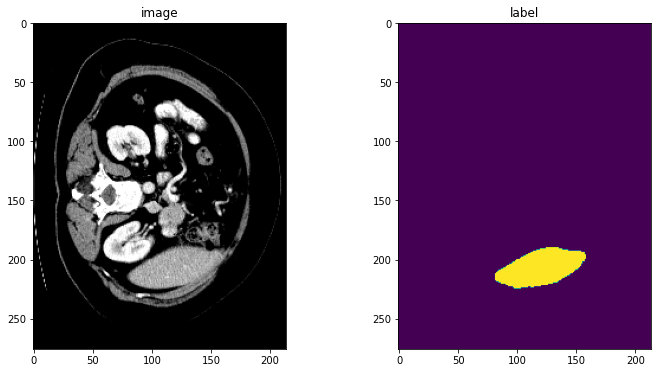

In [29]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 140], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 140])
plt.show()

In [44]:
train_ds = CacheDataset(data=train_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Load and cache transformed data:   0%|          | 0/13 [00:00<?, ?it/s]/home/roshansk/Covid_Bert/env/lib/python3.6/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Load and cache transformed data: 100%|██████████| 7/7 [00:13<00:00,  2.00s/it]


In [45]:
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [50]:
epoch_num = 600
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                    to_onehot_y=True,
                    mutually_exclusive=True,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )

----------
epoch 1/600
1/6, train_loss: 0.5904
2/6, train_loss: 0.6013
3/6, train_loss: 0.6083
4/6, train_loss: 0.6104
5/6, train_loss: 0.5926
6/6, train_loss: 0.5985
7/6, train_loss: 0.5926
epoch 1 average loss: 0.5992
----------
epoch 2/600
1/6, train_loss: 0.6017
2/6, train_loss: 0.5925
3/6, train_loss: 0.5838
4/6, train_loss: 0.5745
5/6, train_loss: 0.5968
6/6, train_loss: 0.5551
7/6, train_loss: 0.5915
epoch 2 average loss: 0.5851
saved new best metric model
current epoch: 2 current mean dice: 0.1698
best mean dice: 0.1698 at epoch: 2
----------
epoch 3/600
1/6, train_loss: 0.6011
2/6, train_loss: 0.5787
3/6, train_loss: 0.5727
4/6, train_loss: 0.5676
5/6, train_loss: 0.5765
6/6, train_loss: 0.5681
7/6, train_loss: 0.5139
epoch 3 average loss: 0.5684
----------
epoch 4/600
1/6, train_loss: 0.5844
2/6, train_loss: 0.5664
3/6, train_loss: 0.5359
4/6, train_loss: 0.5607
5/6, train_loss: 0.5650
6/6, train_loss: 0.5582
7/6, train_loss: 0.5944
epoch 4 average loss: 0.5664
saved new best

5/6, train_loss: 0.4776
6/6, train_loss: 0.4522
7/6, train_loss: 0.4296
epoch 31 average loss: 0.4491
----------
epoch 32/600
1/6, train_loss: 0.4390
2/6, train_loss: 0.4412
3/6, train_loss: 0.4417
4/6, train_loss: 0.4497
5/6, train_loss: 0.4226
6/6, train_loss: 0.4826
7/6, train_loss: 0.4594
epoch 32 average loss: 0.4480
current epoch: 32 current mean dice: 0.4234
best mean dice: 0.4493 at epoch: 30
----------
epoch 33/600
1/6, train_loss: 0.4650
2/6, train_loss: 0.4133
3/6, train_loss: 0.4371
4/6, train_loss: 0.4427
5/6, train_loss: 0.4496
6/6, train_loss: 0.4654
7/6, train_loss: 0.4224
epoch 33 average loss: 0.4422
----------
epoch 34/600
1/6, train_loss: 0.4579
2/6, train_loss: 0.4423
3/6, train_loss: 0.4120
4/6, train_loss: 0.4587
5/6, train_loss: 0.4218
6/6, train_loss: 0.4508
7/6, train_loss: 0.4380
epoch 34 average loss: 0.4402
current epoch: 34 current mean dice: 0.4414
best mean dice: 0.4493 at epoch: 30
----------
epoch 35/600
1/6, train_loss: 0.3874
2/6, train_loss: 0.4375


1/6, train_loss: 0.3013
2/6, train_loss: 0.3409
3/6, train_loss: 0.3700
4/6, train_loss: 0.3450
5/6, train_loss: 0.3629
6/6, train_loss: 0.3422
7/6, train_loss: 0.3722
epoch 62 average loss: 0.3478
saved new best metric model
current epoch: 62 current mean dice: 0.6840
best mean dice: 0.6840 at epoch: 62
----------
epoch 63/600
1/6, train_loss: 0.3349
2/6, train_loss: 0.3315
3/6, train_loss: 0.3330
4/6, train_loss: 0.3743
5/6, train_loss: 0.2886
6/6, train_loss: 0.3801
7/6, train_loss: 0.3679
epoch 63 average loss: 0.3443
----------
epoch 64/600
1/6, train_loss: 0.3351
2/6, train_loss: 0.3357
3/6, train_loss: 0.3401
4/6, train_loss: 0.3315
5/6, train_loss: 0.3119
6/6, train_loss: 0.3454
7/6, train_loss: 0.4015
epoch 64 average loss: 0.3430
saved new best metric model
current epoch: 64 current mean dice: 0.7018
best mean dice: 0.7018 at epoch: 64
----------
epoch 65/600
1/6, train_loss: 0.3469
2/6, train_loss: 0.3612
3/6, train_loss: 0.3434
4/6, train_loss: 0.3003
5/6, train_loss: 0.315

epoch 92 average loss: 0.2359
current epoch: 92 current mean dice: 0.7230
best mean dice: 0.7403 at epoch: 88
----------
epoch 93/600
1/6, train_loss: 0.2489
2/6, train_loss: 0.2325
3/6, train_loss: 0.2862
4/6, train_loss: 0.2616
5/6, train_loss: 0.2251
6/6, train_loss: 0.2178
7/6, train_loss: 0.1586
epoch 93 average loss: 0.2329
----------
epoch 94/600
1/6, train_loss: 0.2116
2/6, train_loss: 0.2529
3/6, train_loss: 0.2484
4/6, train_loss: 0.1900
5/6, train_loss: 0.2820
6/6, train_loss: 0.2192
7/6, train_loss: 0.2475
epoch 94 average loss: 0.2359
current epoch: 94 current mean dice: 0.7385
best mean dice: 0.7403 at epoch: 88
----------
epoch 95/600
1/6, train_loss: 0.2658
2/6, train_loss: 0.2409
3/6, train_loss: 0.2020
4/6, train_loss: 0.2547
5/6, train_loss: 0.2105
6/6, train_loss: 0.2094
7/6, train_loss: 0.2439
epoch 95 average loss: 0.2324
----------
epoch 96/600
1/6, train_loss: 0.2371
2/6, train_loss: 0.2126
3/6, train_loss: 0.2099
4/6, train_loss: 0.2542
5/6, train_loss: 0.2611


7/6, train_loss: 0.1431
epoch 123 average loss: 0.1512
----------
epoch 124/600
1/6, train_loss: 0.1666
2/6, train_loss: 0.1291
3/6, train_loss: 0.1227
4/6, train_loss: 0.1782
5/6, train_loss: 0.1752
6/6, train_loss: 0.1399
7/6, train_loss: 0.1339
epoch 124 average loss: 0.1494
current epoch: 124 current mean dice: 0.6938
best mean dice: 0.7403 at epoch: 88
----------
epoch 125/600
1/6, train_loss: 0.1443
2/6, train_loss: 0.1757
3/6, train_loss: 0.1497
4/6, train_loss: 0.1505
5/6, train_loss: 0.1408
6/6, train_loss: 0.1293
7/6, train_loss: 0.1374
epoch 125 average loss: 0.1468
----------
epoch 126/600
1/6, train_loss: 0.1459
2/6, train_loss: 0.1572
3/6, train_loss: 0.1077
4/6, train_loss: 0.1417
5/6, train_loss: 0.1501
6/6, train_loss: 0.1791
7/6, train_loss: 0.1326
epoch 126 average loss: 0.1449
current epoch: 126 current mean dice: 0.6990
best mean dice: 0.7403 at epoch: 88
----------
epoch 127/600
1/6, train_loss: 0.1577
2/6, train_loss: 0.1481
3/6, train_loss: 0.1498
4/6, train_los

current epoch: 154 current mean dice: 0.7186
best mean dice: 0.7403 at epoch: 88
----------
epoch 155/600
1/6, train_loss: 0.0831
2/6, train_loss: 0.0886
3/6, train_loss: 0.1028
4/6, train_loss: 0.0821
5/6, train_loss: 0.1253
6/6, train_loss: 0.0916
7/6, train_loss: 0.0804
epoch 155 average loss: 0.0934
----------
epoch 156/600
1/6, train_loss: 0.0933
2/6, train_loss: 0.0830
3/6, train_loss: 0.0880
4/6, train_loss: 0.0808
5/6, train_loss: 0.0908
6/6, train_loss: 0.1128
7/6, train_loss: 0.1066
epoch 156 average loss: 0.0936
current epoch: 156 current mean dice: 0.7111
best mean dice: 0.7403 at epoch: 88
----------
epoch 157/600
1/6, train_loss: 0.0880
2/6, train_loss: 0.0768
3/6, train_loss: 0.0959
4/6, train_loss: 0.1094
5/6, train_loss: 0.1002
6/6, train_loss: 0.0808
7/6, train_loss: 0.0872
epoch 157 average loss: 0.0912
----------
epoch 158/600
1/6, train_loss: 0.0955
2/6, train_loss: 0.0807
3/6, train_loss: 0.0726
4/6, train_loss: 0.0857
5/6, train_loss: 0.0933
6/6, train_loss: 0.10

epoch 185 average loss: 0.0644
----------
epoch 186/600
1/6, train_loss: 0.0607
2/6, train_loss: 0.0744
3/6, train_loss: 0.0713
4/6, train_loss: 0.0634
5/6, train_loss: 0.0595
6/6, train_loss: 0.0555
7/6, train_loss: 0.0577
epoch 186 average loss: 0.0632
current epoch: 186 current mean dice: 0.7133
best mean dice: 0.7403 at epoch: 88
----------
epoch 187/600
1/6, train_loss: 0.0616
2/6, train_loss: 0.0730
3/6, train_loss: 0.0522
4/6, train_loss: 0.0537
5/6, train_loss: 0.0755
6/6, train_loss: 0.0638
7/6, train_loss: 0.0575
epoch 187 average loss: 0.0625
----------
epoch 188/600
1/6, train_loss: 0.0670
2/6, train_loss: 0.0519
3/6, train_loss: 0.0578
4/6, train_loss: 0.0681
5/6, train_loss: 0.0538
6/6, train_loss: 0.0590
7/6, train_loss: 0.0965
epoch 188 average loss: 0.0649
current epoch: 188 current mean dice: 0.7192
best mean dice: 0.7403 at epoch: 88
----------
epoch 189/600
1/6, train_loss: 0.0788
2/6, train_loss: 0.0743
3/6, train_loss: 0.0548
4/6, train_loss: 0.0526
5/6, train_los

1/6, train_loss: 0.0470
2/6, train_loss: 0.0479
3/6, train_loss: 0.0434
4/6, train_loss: 0.0473
5/6, train_loss: 0.0393
6/6, train_loss: 0.0545
7/6, train_loss: 0.0390
epoch 217 average loss: 0.0455
----------
epoch 218/600
1/6, train_loss: 0.0337
2/6, train_loss: 0.0455
3/6, train_loss: 0.0401
4/6, train_loss: 0.0531
5/6, train_loss: 0.0527
6/6, train_loss: 0.0448
7/6, train_loss: 0.0518
epoch 218 average loss: 0.0460
current epoch: 218 current mean dice: 0.7135
best mean dice: 0.7403 at epoch: 88
----------
epoch 219/600
1/6, train_loss: 0.0482
2/6, train_loss: 0.0460
3/6, train_loss: 0.0454
4/6, train_loss: 0.0381
5/6, train_loss: 0.0429
6/6, train_loss: 0.0456
7/6, train_loss: 0.0508
epoch 219 average loss: 0.0453
----------
epoch 220/600
1/6, train_loss: 0.0434
2/6, train_loss: 0.0521
3/6, train_loss: 0.0401
4/6, train_loss: 0.0336
5/6, train_loss: 0.0495
6/6, train_loss: 0.0531
7/6, train_loss: 0.0391
epoch 220 average loss: 0.0444
current epoch: 220 current mean dice: 0.7077
bes

4/6, train_loss: 0.0286
5/6, train_loss: 0.0318
6/6, train_loss: 0.0384
7/6, train_loss: 0.0317
epoch 248 average loss: 0.0348
current epoch: 248 current mean dice: 0.7078
best mean dice: 0.7403 at epoch: 88
----------
epoch 249/600
1/6, train_loss: 0.0352
2/6, train_loss: 0.0322
3/6, train_loss: 0.0341
4/6, train_loss: 0.0431
5/6, train_loss: 0.0368
6/6, train_loss: 0.0310
7/6, train_loss: 0.0303
epoch 249 average loss: 0.0347
----------
epoch 250/600
1/6, train_loss: 0.0316
2/6, train_loss: 0.0398
3/6, train_loss: 0.0410
4/6, train_loss: 0.0291
5/6, train_loss: 0.0329
6/6, train_loss: 0.0333
7/6, train_loss: 0.0336
epoch 250 average loss: 0.0345
current epoch: 250 current mean dice: 0.7027
best mean dice: 0.7403 at epoch: 88
----------
epoch 251/600
1/6, train_loss: 0.0353
2/6, train_loss: 0.0376
3/6, train_loss: 0.0442
4/6, train_loss: 0.0370
5/6, train_loss: 0.0298
6/6, train_loss: 0.0302
7/6, train_loss: 0.0226
epoch 251 average loss: 0.0338
----------
epoch 252/600
1/6, train_los

4/6, train_loss: 0.0279
5/6, train_loss: 0.0287
6/6, train_loss: 0.0273
7/6, train_loss: 0.0351
epoch 279 average loss: 0.0294
----------
epoch 280/600
1/6, train_loss: 0.0307
2/6, train_loss: 0.0328
3/6, train_loss: 0.0264
4/6, train_loss: 0.0269
5/6, train_loss: 0.0275
6/6, train_loss: 0.0279
7/6, train_loss: 0.0363
epoch 280 average loss: 0.0298
current epoch: 280 current mean dice: 0.7026
best mean dice: 0.7403 at epoch: 88
----------
epoch 281/600
1/6, train_loss: 0.0276
2/6, train_loss: 0.0281
3/6, train_loss: 0.0279
4/6, train_loss: 0.0289
5/6, train_loss: 0.0243
6/6, train_loss: 0.0360
7/6, train_loss: 0.0190
epoch 281 average loss: 0.0274
----------
epoch 282/600
1/6, train_loss: 0.0274
2/6, train_loss: 0.0359
3/6, train_loss: 0.0300
4/6, train_loss: 0.0214
5/6, train_loss: 0.0295
6/6, train_loss: 0.0260
7/6, train_loss: 0.0240
epoch 282 average loss: 0.0278
current epoch: 282 current mean dice: 0.7084
best mean dice: 0.7403 at epoch: 88
----------
epoch 283/600
1/6, train_los

7/6, train_loss: 0.0203
epoch 310 average loss: 0.0230
current epoch: 310 current mean dice: 0.6855
best mean dice: 0.7403 at epoch: 88
----------
epoch 311/600
1/6, train_loss: 0.0262
2/6, train_loss: 0.0180
3/6, train_loss: 0.0264
4/6, train_loss: 0.0230
5/6, train_loss: 0.0208
6/6, train_loss: 0.0225
7/6, train_loss: 0.0257
epoch 311 average loss: 0.0232
----------
epoch 312/600
1/6, train_loss: 0.0226
2/6, train_loss: 0.0240
3/6, train_loss: 0.0208
4/6, train_loss: 0.0194
5/6, train_loss: 0.0305
6/6, train_loss: 0.0217
7/6, train_loss: 0.0201
epoch 312 average loss: 0.0227
current epoch: 312 current mean dice: 0.6875
best mean dice: 0.7403 at epoch: 88
----------
epoch 313/600
1/6, train_loss: 0.0232
2/6, train_loss: 0.0224
3/6, train_loss: 0.0251
4/6, train_loss: 0.0246
5/6, train_loss: 0.0188
6/6, train_loss: 0.0273
7/6, train_loss: 0.0208
epoch 313 average loss: 0.0232
----------
epoch 314/600
1/6, train_loss: 0.0255
2/6, train_loss: 0.0238
3/6, train_loss: 0.0266
4/6, train_los

6/6, train_loss: 0.0179
7/6, train_loss: 0.0139
epoch 341 average loss: 0.0188
----------
epoch 342/600
1/6, train_loss: 0.0180
2/6, train_loss: 0.0148
3/6, train_loss: 0.0252
4/6, train_loss: 0.0178
5/6, train_loss: 0.0241
6/6, train_loss: 0.0170
7/6, train_loss: 0.0193
epoch 342 average loss: 0.0194
current epoch: 342 current mean dice: 0.6691
best mean dice: 0.7403 at epoch: 88
----------
epoch 343/600
1/6, train_loss: 0.0204
2/6, train_loss: 0.0171
3/6, train_loss: 0.0198
4/6, train_loss: 0.0231
5/6, train_loss: 0.0165
6/6, train_loss: 0.0180
7/6, train_loss: 0.0208
epoch 343 average loss: 0.0194
----------
epoch 344/600
1/6, train_loss: 0.0185
2/6, train_loss: 0.0207
3/6, train_loss: 0.0192
4/6, train_loss: 0.0177
5/6, train_loss: 0.0164
6/6, train_loss: 0.0216
7/6, train_loss: 0.0168
epoch 344 average loss: 0.0187
current epoch: 344 current mean dice: 0.6863
best mean dice: 0.7403 at epoch: 88
----------
epoch 345/600
1/6, train_loss: 0.0191
2/6, train_loss: 0.0196
3/6, train_los

epoch 372 average loss: 0.0159
current epoch: 372 current mean dice: 0.6834
best mean dice: 0.7403 at epoch: 88
----------
epoch 373/600
1/6, train_loss: 0.0173
2/6, train_loss: 0.0154
3/6, train_loss: 0.0152
4/6, train_loss: 0.0197
5/6, train_loss: 0.0152
6/6, train_loss: 0.0123
7/6, train_loss: 0.0134
epoch 373 average loss: 0.0155
----------
epoch 374/600
1/6, train_loss: 0.0150
2/6, train_loss: 0.0176
3/6, train_loss: 0.0166
4/6, train_loss: 0.0150
5/6, train_loss: 0.0137
6/6, train_loss: 0.0163
7/6, train_loss: 0.0139
epoch 374 average loss: 0.0154
current epoch: 374 current mean dice: 0.6846
best mean dice: 0.7403 at epoch: 88
----------
epoch 375/600
1/6, train_loss: 0.0153
2/6, train_loss: 0.0146
3/6, train_loss: 0.0151
4/6, train_loss: 0.0156
5/6, train_loss: 0.0147
6/6, train_loss: 0.0150
7/6, train_loss: 0.0186
epoch 375 average loss: 0.0156
----------
epoch 376/600
1/6, train_loss: 0.0174
2/6, train_loss: 0.0145
3/6, train_loss: 0.0146
4/6, train_loss: 0.0167
5/6, train_los

epoch 403 average loss: 0.0141
----------
epoch 404/600
1/6, train_loss: 0.0131
2/6, train_loss: 0.0167
3/6, train_loss: 0.0118
4/6, train_loss: 0.0128
5/6, train_loss: 0.0129
6/6, train_loss: 0.0133
7/6, train_loss: 0.0142
epoch 404 average loss: 0.0135
current epoch: 404 current mean dice: 0.6896
best mean dice: 0.7403 at epoch: 88
----------
epoch 405/600
1/6, train_loss: 0.0119
2/6, train_loss: 0.0119
3/6, train_loss: 0.0129
4/6, train_loss: 0.0153
5/6, train_loss: 0.0123
6/6, train_loss: 0.0184
7/6, train_loss: 0.0163
epoch 405 average loss: 0.0142
----------
epoch 406/600
1/6, train_loss: 0.0122
2/6, train_loss: 0.0125
3/6, train_loss: 0.0124
4/6, train_loss: 0.0140
5/6, train_loss: 0.0145
6/6, train_loss: 0.0176
7/6, train_loss: 0.0114
epoch 406 average loss: 0.0135
current epoch: 406 current mean dice: 0.6860
best mean dice: 0.7403 at epoch: 88
----------
epoch 407/600
1/6, train_loss: 0.0125
2/6, train_loss: 0.0147
3/6, train_loss: 0.0132
4/6, train_loss: 0.0142
5/6, train_los

1/6, train_loss: 0.0109
2/6, train_loss: 0.0125
3/6, train_loss: 0.0113
4/6, train_loss: 0.0117
5/6, train_loss: 0.0140
6/6, train_loss: 0.0119
7/6, train_loss: 0.0088
epoch 435 average loss: 0.0116
----------
epoch 436/600
1/6, train_loss: 0.0142
2/6, train_loss: 0.0107
3/6, train_loss: 0.0110
4/6, train_loss: 0.0116
5/6, train_loss: 0.0114
6/6, train_loss: 0.0103
7/6, train_loss: 0.0117
epoch 436 average loss: 0.0116
current epoch: 436 current mean dice: 0.6676
best mean dice: 0.7403 at epoch: 88
----------
epoch 437/600
1/6, train_loss: 0.0139
2/6, train_loss: 0.0119
3/6, train_loss: 0.0119
4/6, train_loss: 0.0112
5/6, train_loss: 0.0118
6/6, train_loss: 0.0105
7/6, train_loss: 0.0146
epoch 437 average loss: 0.0123
----------
epoch 438/600
1/6, train_loss: 0.0111
2/6, train_loss: 0.0094
3/6, train_loss: 0.0122
4/6, train_loss: 0.0149
5/6, train_loss: 0.0113
6/6, train_loss: 0.0122
7/6, train_loss: 0.0118
epoch 438 average loss: 0.0118
current epoch: 438 current mean dice: 0.6910
bes

3/6, train_loss: 0.0109
4/6, train_loss: 0.0098
5/6, train_loss: 0.0109
6/6, train_loss: 0.0096
7/6, train_loss: 0.0151
epoch 466 average loss: 0.0111
current epoch: 466 current mean dice: 0.7009
best mean dice: 0.7403 at epoch: 88
----------
epoch 467/600
1/6, train_loss: 0.0116
2/6, train_loss: 0.0104
3/6, train_loss: 0.0122
4/6, train_loss: 0.0111
5/6, train_loss: 0.0117
6/6, train_loss: 0.0093
7/6, train_loss: 0.0116
epoch 467 average loss: 0.0111
----------
epoch 468/600
1/6, train_loss: 0.0099
2/6, train_loss: 0.0107
3/6, train_loss: 0.0108
4/6, train_loss: 0.0125
5/6, train_loss: 0.0098
6/6, train_loss: 0.0095
7/6, train_loss: 0.0131
epoch 468 average loss: 0.0109
current epoch: 468 current mean dice: 0.6930
best mean dice: 0.7403 at epoch: 88
----------
epoch 469/600
1/6, train_loss: 0.0126
2/6, train_loss: 0.0098
3/6, train_loss: 0.0100
4/6, train_loss: 0.0107
5/6, train_loss: 0.0095
6/6, train_loss: 0.0092
7/6, train_loss: 0.0103
epoch 469 average loss: 0.0103
----------
epoc

4/6, train_loss: 0.0096
5/6, train_loss: 0.0079
6/6, train_loss: 0.0087
7/6, train_loss: 0.0087
epoch 497 average loss: 0.0084
----------
epoch 498/600
1/6, train_loss: 0.0100
2/6, train_loss: 0.0084
3/6, train_loss: 0.0078
4/6, train_loss: 0.0082
5/6, train_loss: 0.0077
6/6, train_loss: 0.0073
7/6, train_loss: 0.0092
epoch 498 average loss: 0.0084
current epoch: 498 current mean dice: 0.6901
best mean dice: 0.7403 at epoch: 88
----------
epoch 499/600
1/6, train_loss: 0.0100
2/6, train_loss: 0.0072
3/6, train_loss: 0.0078
4/6, train_loss: 0.0089
5/6, train_loss: 0.0083
6/6, train_loss: 0.0075
7/6, train_loss: 0.0093
epoch 499 average loss: 0.0084
----------
epoch 500/600
1/6, train_loss: 0.0070
2/6, train_loss: 0.0080
3/6, train_loss: 0.0094
4/6, train_loss: 0.0089
5/6, train_loss: 0.0083
6/6, train_loss: 0.0079
7/6, train_loss: 0.0091
epoch 500 average loss: 0.0084
current epoch: 500 current mean dice: 0.6918
best mean dice: 0.7403 at epoch: 88
----------
epoch 501/600
1/6, train_los

6/6, train_loss: 0.0084
7/6, train_loss: 0.0088
epoch 528 average loss: 0.0091
current epoch: 528 current mean dice: 0.6746
best mean dice: 0.7403 at epoch: 88
----------
epoch 529/600
1/6, train_loss: 0.0091
2/6, train_loss: 0.0096
3/6, train_loss: 0.0117
4/6, train_loss: 0.0080
5/6, train_loss: 0.0069
6/6, train_loss: 0.0087
7/6, train_loss: 0.0135
epoch 529 average loss: 0.0096
----------
epoch 530/600
1/6, train_loss: 0.0118
2/6, train_loss: 0.0076
3/6, train_loss: 0.0077
4/6, train_loss: 0.0098
5/6, train_loss: 0.0118
6/6, train_loss: 0.0107
7/6, train_loss: 0.0078
epoch 530 average loss: 0.0096
current epoch: 530 current mean dice: 0.7011
best mean dice: 0.7403 at epoch: 88
----------
epoch 531/600
1/6, train_loss: 0.0079
2/6, train_loss: 0.0084
3/6, train_loss: 0.0107
4/6, train_loss: 0.0077
5/6, train_loss: 0.0098
6/6, train_loss: 0.0099
7/6, train_loss: 0.0076
epoch 531 average loss: 0.0089
----------
epoch 532/600
1/6, train_loss: 0.0080
2/6, train_loss: 0.0076
3/6, train_los

5/6, train_loss: 0.0060
6/6, train_loss: 0.0072
7/6, train_loss: 0.0073
epoch 559 average loss: 0.0064
----------
epoch 560/600
1/6, train_loss: 0.0065
2/6, train_loss: 0.0062
3/6, train_loss: 0.0080
4/6, train_loss: 0.0055
5/6, train_loss: 0.0060
6/6, train_loss: 0.0059
7/6, train_loss: 0.0061
epoch 560 average loss: 0.0063
current epoch: 560 current mean dice: 0.6879
best mean dice: 0.7403 at epoch: 88
----------
epoch 561/600
1/6, train_loss: 0.0057
2/6, train_loss: 0.0064
3/6, train_loss: 0.0077
4/6, train_loss: 0.0066
5/6, train_loss: 0.0056
6/6, train_loss: 0.0064
7/6, train_loss: 0.0059
epoch 561 average loss: 0.0063
----------
epoch 562/600
1/6, train_loss: 0.0065
2/6, train_loss: 0.0052
3/6, train_loss: 0.0064
4/6, train_loss: 0.0075
5/6, train_loss: 0.0061
6/6, train_loss: 0.0060
7/6, train_loss: 0.0057
epoch 562 average loss: 0.0062
current epoch: 562 current mean dice: 0.6913
best mean dice: 0.7403 at epoch: 88
----------
epoch 563/600
1/6, train_loss: 0.0058
2/6, train_los

7/6, train_loss: 0.0065
epoch 590 average loss: 0.0064
current epoch: 590 current mean dice: 0.6835
best mean dice: 0.7403 at epoch: 88
----------
epoch 591/600
1/6, train_loss: 0.0057
2/6, train_loss: 0.0074
3/6, train_loss: 0.0067
4/6, train_loss: 0.0060
5/6, train_loss: 0.0057
6/6, train_loss: 0.0067
7/6, train_loss: 0.0049
epoch 591 average loss: 0.0061
----------
epoch 592/600
1/6, train_loss: 0.0059
2/6, train_loss: 0.0068
3/6, train_loss: 0.0061
4/6, train_loss: 0.0065
5/6, train_loss: 0.0072
6/6, train_loss: 0.0059
7/6, train_loss: 0.0053
epoch 592 average loss: 0.0062
current epoch: 592 current mean dice: 0.6708
best mean dice: 0.7403 at epoch: 88
----------
epoch 593/600
1/6, train_loss: 0.0062
2/6, train_loss: 0.0070
3/6, train_loss: 0.0059
4/6, train_loss: 0.0059
5/6, train_loss: 0.0058
6/6, train_loss: 0.0066
7/6, train_loss: 0.0056
epoch 593 average loss: 0.0061
----------
epoch 594/600
1/6, train_loss: 0.0070
2/6, train_loss: 0.0057
3/6, train_loss: 0.0061
4/6, train_los